In [1]:
!pip install pandas numpy xgboost scikit-learn seaborn

In [2]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load Preprocessed Data
train_path = "processed_test.csv"
test_path = "processed_test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Ensure no NaN values in 'processed_text'
train_df['processed_text'] = train_df['processed_text'].fillna("").astype(str)
test_df['processed_text'] = test_df['processed_text'].fillna("").astype(str)

In [4]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Transform the data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_text'])

# Extract target labels for both category and subcategory
y_train_category = train_df['new_category']
y_test_category = test_df['new_category']

y_train_subcategory = train_df['new_sub_category']
y_test_subcategory = test_df['new_sub_category']

print("\nTF-IDF Vectorization Complete:")
print(f"Train Shape: {X_train_tfidf.shape}, Test Shape: {X_test_tfidf.shape}")


TF-IDF Vectorization Complete:
Train Shape: (31229, 5000), Test Shape: (31229, 5000)


In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder_category = LabelEncoder()
label_encoder_subcategory = LabelEncoder()

# Encode the 'new_category' and 'new_sub_category' labels
y_train_category_encoded = label_encoder_category.fit_transform(y_train_category)
y_test_category_encoded = label_encoder_category.transform(y_test_category)

y_train_subcategory_encoded = label_encoder_subcategory.fit_transform(y_train_subcategory)
y_test_subcategory_encoded = label_encoder_subcategory.transform(y_test_subcategory)

# Check the encoded labels
print(f"Encoded Category Labels:\n{y_train_category_encoded[:10]}")
print(f"Encoded Subcategory Labels:\n{y_train_subcategory_encoded[:10]}")

Encoded Category Labels:
[2 0 1 0 1 0 1 0 0 0]
Encoded Subcategory Labels:
[32  6 31 15 24 17 24 29 17  6]


In [6]:
!pip install lightgbm scikit-learn

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283448
[LightGBM] [Info] Number of data points in the train set: 31229, number of used features: 4979
[LightGBM] [Info] Start training from score -0.502397
[LightGBM] [Info] Start training from score -1.666903
[LightGBM] [Info] Start training from score -1.579440

LightGBM Category Classification Metrics:
Training Accuracy: 0.8675589996477633
Testing Accuracy: 0.8675589996477633
Precision: 0.8682262560130188
Recall: 0.8675589996477633
F1 Score: 0.8611902523656341
Log Loss: 0.35555153331791695
AUC: 0.9639162371180019


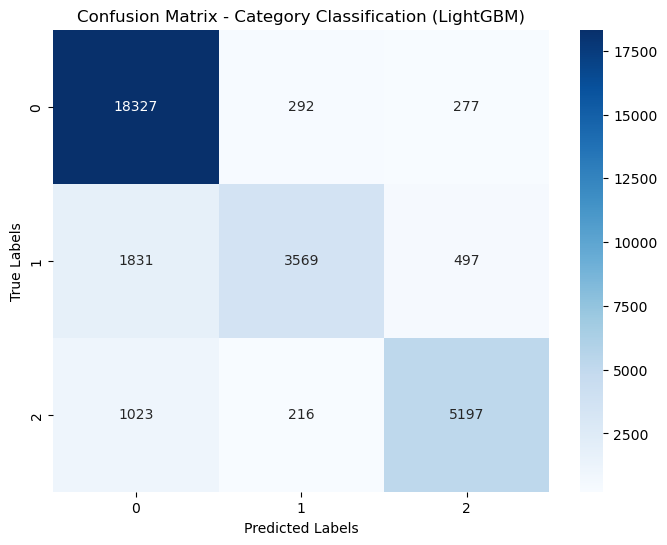


Classification Report (Category - LightGBM):
              precision    recall  f1-score   support

           0       0.87      0.97      0.91     18896
           1       0.88      0.61      0.72      5897
           2       0.87      0.81      0.84      6436

    accuracy                           0.87     31229
   macro avg       0.87      0.79      0.82     31229
weighted avg       0.87      0.87      0.86     31229



In [7]:
# Required Libraries
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, log_loss
)
import matplotlib.pyplot as plt
import seaborn as sns

# Define the LightGBM Classifier for Category Classification
lgbm_category = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42)

# Train the model
lgbm_category.fit(X_train_tfidf, y_train_category_encoded)

# Predict on Test Data
y_pred_category_lgbm = lgbm_category.predict(X_test_tfidf)
y_pred_category_proba = lgbm_category.predict_proba(X_test_tfidf)

# Training Accuracy
train_accuracy_category = accuracy_score(
    y_train_category_encoded, lgbm_category.predict(X_train_tfidf)
)

# Testing Accuracy
test_accuracy_category = accuracy_score(y_test_category_encoded, y_pred_category_lgbm)

# Precision, Recall, F1 Score
precision_category = precision_score(
    y_test_category_encoded, y_pred_category_lgbm, average='weighted'
)
recall_category = recall_score(
    y_test_category_encoded, y_pred_category_lgbm, average='weighted'
)
f1_category = f1_score(
    y_test_category_encoded, y_pred_category_lgbm, average='weighted'
)

# Log Loss
log_loss_category = log_loss(y_test_category_encoded, y_pred_category_proba)

# AUC (Area Under the Curve)
auc_category = roc_auc_score(
    y_test_category_encoded, y_pred_category_proba, multi_class='ovr'
)

# Confusion Matrix
conf_matrix_category = confusion_matrix(y_test_category_encoded, y_pred_category_lgbm)

# Display Metrics
print("\nLightGBM Category Classification Metrics:")
print(f"Training Accuracy: {train_accuracy_category}")
print(f"Testing Accuracy: {test_accuracy_category}")
print(f"Precision: {precision_category}")
print(f"Recall: {recall_category}")
print(f"F1 Score: {f1_category}")
print(f"Log Loss: {log_loss_category}")
print(f"AUC: {auc_category}")

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_category, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title("Confusion Matrix - Category Classification (LightGBM)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("\nClassification Report (Category - LightGBM):")
print(classification_report(y_test_category_encoded, y_pred_category_lgbm))

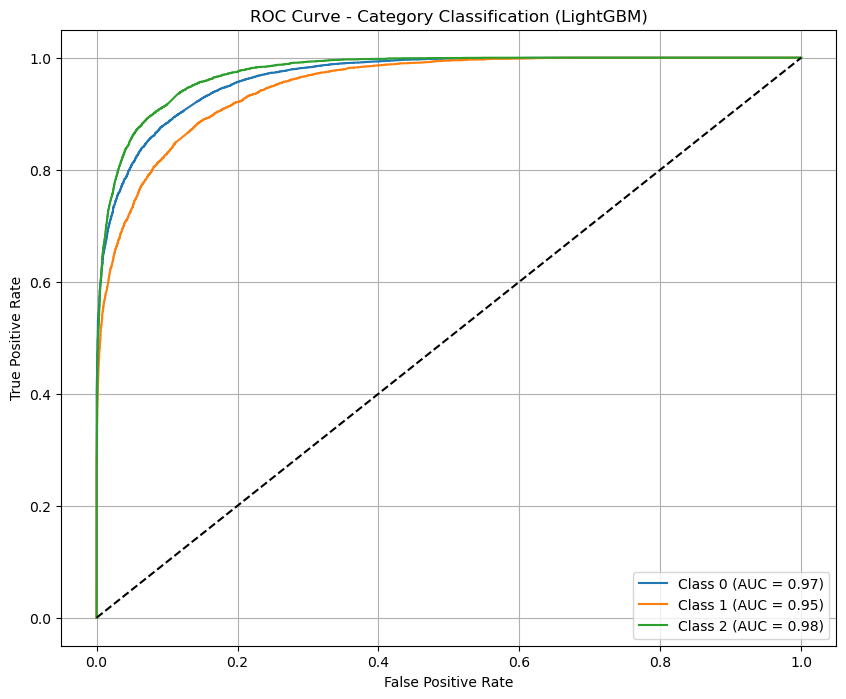

In [8]:
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(3):  # Adjust range based on the number of classes
    fpr, tpr, _ = roc_curve(y_test_category_encoded == i, y_pred_category_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.title("ROC Curve - Category Classification (LightGBM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

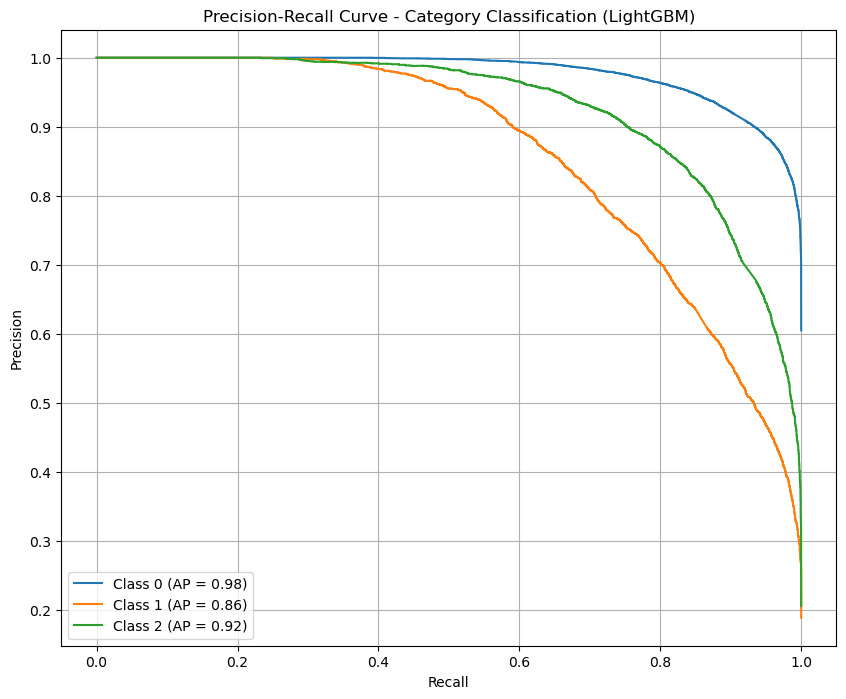

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(3):  # Adjust range based on the number of classes
    precision, recall, _ = precision_recall_curve(y_test_category_encoded == i, y_pred_category_proba[:, i])
    avg_precision = average_precision_score(y_test_category_encoded == i, y_pred_category_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')

plt.title("Precision-Recall Curve - Category Classification (LightGBM)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210059
[LightGBM] [Info] Number of data points in the train set: 20819, number of used features: 4908
[LightGBM] [Info] Start training from score -0.502328
[LightGBM] [Info] Start training from score -1.666972
[LightGBM] [Info] Start training from score -1.579579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210059
[LightGBM] [Info] Number of data points in the train set: 20819, number of used features: 4908
[LightGBM] [Info] Start training from score -0.502328
[LightGBM] [Info] Start training from score -1.666972
[LightGBM] [Info

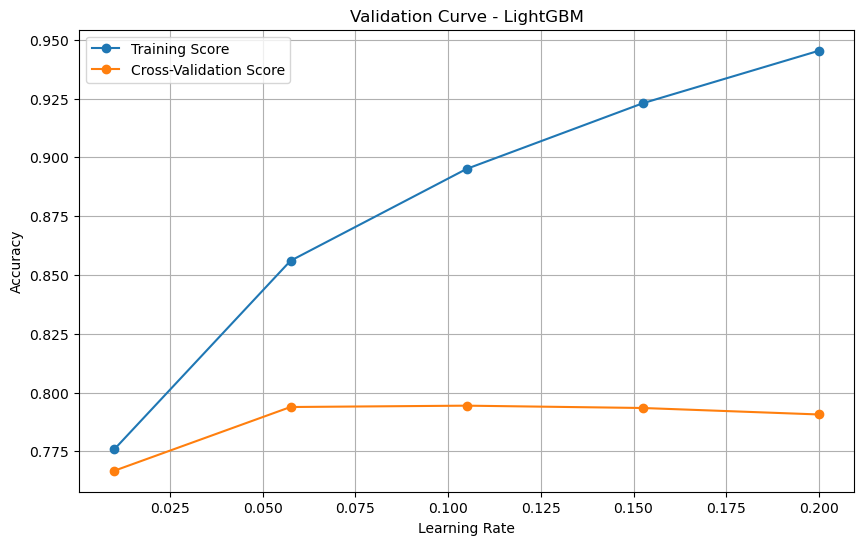

In [10]:
from sklearn.model_selection import validation_curve
import numpy as np

# Define parameter range and calculate validation curve
param_range = np.linspace(0.01, 0.2, 5)  # Example: Learning rates to evaluate
train_scores, test_scores = validation_curve(
    lgbm_category, 
    X_train_tfidf, 
    y_train_category_encoded, 
    param_name="learning_rate", 
    param_range=param_range, 
    cv=3, 
    scoring="accuracy"
)

# Plot Validation Curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores.mean(axis=1), label="Training Score", marker='o')
plt.plot(param_range, test_scores.mean(axis=1), label="Cross-Validation Score", marker='o')
plt.title("Validation Curve - LightGBM")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

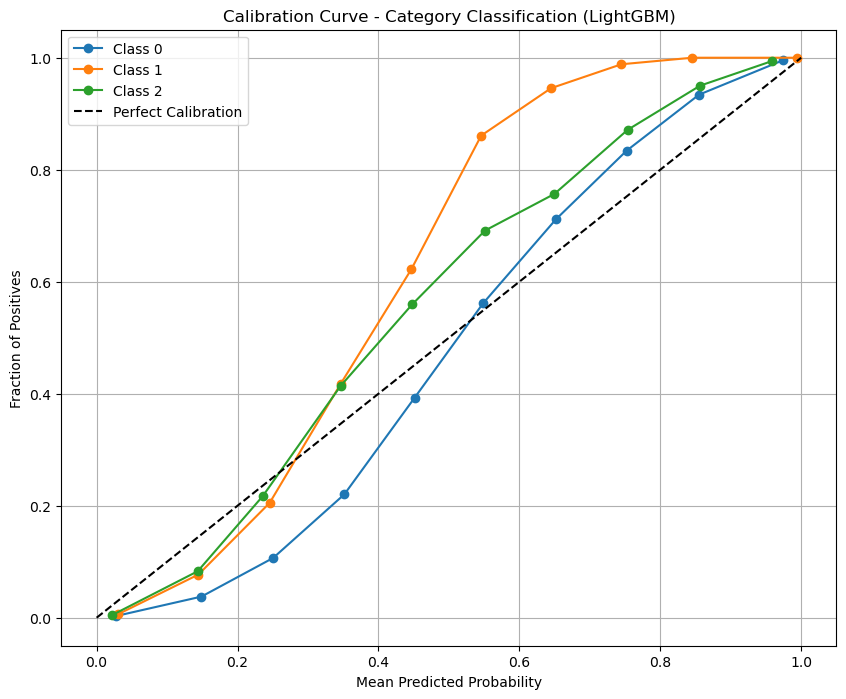

In [11]:
from sklearn.calibration import calibration_curve

# Plot Calibration Curve for each class
plt.figure(figsize=(10, 8))
for i in range(3):  # Adjust range based on the number of classes
    prob_true, prob_pred = calibration_curve(y_test_category_encoded == i, y_pred_category_proba[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.title("Calibration Curve - Category Classification (LightGBM)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend(loc="best")
plt.grid()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210059
[LightGBM] [Info] Number of data points in the train set: 20819, number of used features: 4908
[LightGBM] [Info] Start training from score -0.502328
[LightGBM] [Info] Start training from score -1.666972
[LightGBM] [Info] Start training from score -1.579579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209651
[LightGBM] [Info] Number of data points in the train set: 20819, number of used features: 4905
[LightGBM] [Info] Start training from score -0.502407
[LightGBM] [Info] Start training from score -1.666972
[LightGBM] [Info

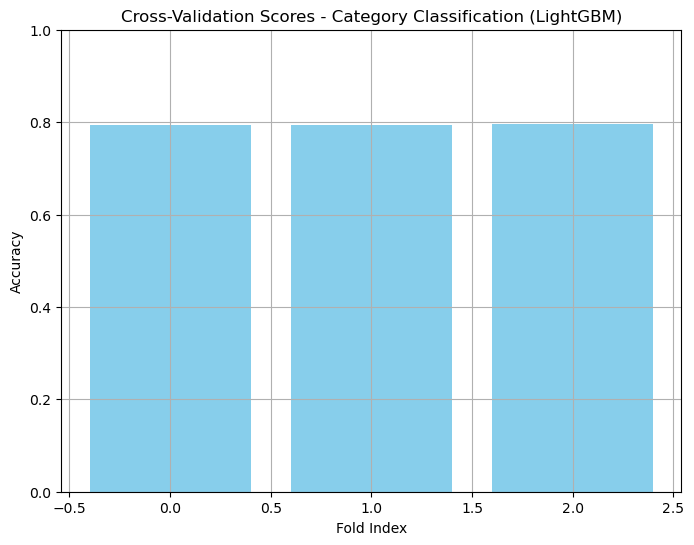

Mean CV Score: 0.7941, Std: 0.0014


In [13]:
from sklearn.model_selection import cross_val_score

# Cross-Validation Scores
cv_scores = cross_val_score(lgbm_category, X_train_tfidf, y_train_category_encoded, cv=3, scoring='accuracy')

# Plot Cross-Validation Scores
plt.figure(figsize=(8, 6))
plt.bar(range(len(cv_scores)), cv_scores, color='skyblue')
plt.title("Cross-Validation Scores - Category Classification (LightGBM)")
plt.xlabel("Fold Index")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid()
plt.show()

print(f"Mean CV Score: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 580727
[LightGBM] [Info] Number of data points in the train set: 93686, number of used features: 5000
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score -0.003100
[LightGBM] [Info] Start training from score -5.777823
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from 

/home/ailab3/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ailab3/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ailab3/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.



LightGBM Sub-category Classification Metrics:
Training Accuracy: 0.5547253591785325
Testing Accuracy: 0.3948253226167985
Precision: 0.652886091861681
Recall: 0.41595952480066606
F1 Score: 0.4880476586282737
Log Loss: 2.0259880769626686


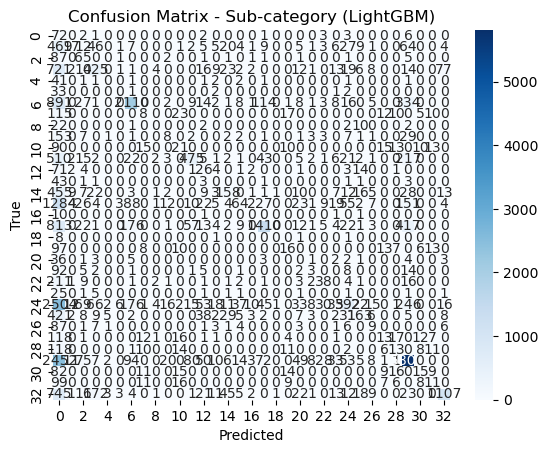


Classification Report (Sub-category - LightGBM):
              precision    recall  f1-score   support

           0       0.02      0.06      0.03        90
           1       0.27      0.02      0.04       719
           2       0.17      0.39      0.23       166
           3       0.55      0.31      0.40      1366
           4       0.00      0.00      0.00        52
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        39
           7       0.78      0.60      0.68      3556
           8       0.11      0.04      0.06       200
           9       0.00      0.00      0.00        39
          10       0.10      0.04      0.05       222
          11       0.17      0.11      0.14       187
          12       0.73      0.36      0.49      1338
          13       0.08      0.20      0.11       130
          14       0.00      0.00      0.00        54
          15       0.50      0.21      0.30       763
          16       0.39      0.

/home/ailab3/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ailab3/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ailab3/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


In [14]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Load preprocessed train and test data
train_df = pd.read_csv('processed_train.csv')
test_df = pd.read_csv('processed_test.csv')

# Ensure there are no NaN values in the 'processed_text' column
train_df['processed_text'] = train_df['processed_text'].fillna('')
test_df['processed_text'] = test_df['processed_text'].fillna('')

# MultiLabelBinarizer to handle multi-label sub-category classification
mlb = MultiLabelBinarizer()

# Convert the 'new_subcategories' column (which contains lists of sub-categories) into binary format
y_train_subcategory = mlb.fit_transform(train_df['new_sub_category'].apply(lambda x: x.split('|')))
y_test_subcategory = mlb.transform(test_df['new_sub_category'].apply(lambda x: x.split('|')))

# Step 1: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_text'])

# Step 2: Initialize the LightGBM Classifier for Sub-category Classification
lgbm_subcategory = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=y_train_subcategory.shape[1],  # Number of unique sub-categories (labels)
    random_state=42,
    device='gpu',  # Enable GPU usage if available
    boosting_type='gbdt',
    metric='multi_logloss'
)

# Step 3: Use OneVsRestClassifier to handle multi-label classification
ovr_classifier = OneVsRestClassifier(lgbm_subcategory)

# Step 4: Train the model
ovr_classifier.fit(X_train_tfidf, y_train_subcategory)

# Step 5: Predict with the trained model
y_pred_subcategory = ovr_classifier.predict(X_test_tfidf)

# Step 6: Metrics for Sub-category Classification
accuracy_subcategory = accuracy_score(y_test_subcategory, y_pred_subcategory)
precision_subcategory = precision_score(y_test_subcategory, y_pred_subcategory, average='weighted')
recall_subcategory = recall_score(y_test_subcategory, y_pred_subcategory, average='weighted')
f1_subcategory = f1_score(y_test_subcategory, y_pred_subcategory, average='weighted')

# Log Loss
log_loss_subcategory = log_loss(y_test_subcategory, ovr_classifier.predict_proba(X_test_tfidf))

# AUC (Area Under the Curve) for multiclass classification
# Display Metrics
print("\nLightGBM Sub-category Classification Metrics:")
print(f"Training Accuracy: {ovr_classifier.score(X_train_tfidf, y_train_subcategory)}")
print(f"Testing Accuracy: {accuracy_subcategory}")
print(f"Precision: {precision_subcategory}")
print(f"Recall: {recall_subcategory}")
print(f"F1 Score: {f1_subcategory}")
print(f"Log Loss: {log_loss_subcategory}")

# Step 7: Confusion Matrix
conf_matrix_subcategory = confusion_matrix(y_test_subcategory.argmax(axis=1), y_pred_subcategory.argmax(axis=1))
sns.heatmap(conf_matrix_subcategory, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Sub-category (LightGBM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Step 8: Classification Report
print("\nClassification Report (Sub-category - LightGBM):")
print(classification_report(y_test_subcategory, y_pred_subcategory))